## Maven Hospital Challenge

#### Challenge Objective

For the Maven Hospital Challenge, you'll play the role of an Analytics Consultant for Massachusetts General Hospital (MGH).

You've been asked to build a high-level KPI report for the executive team, based on a subset of patient records. The purpose of the report is to give stakeholders visibility into the hospital's recent performance, and answer the following questions:

 - How many patients have been admitted or readmitted over time?
 - How long are patients staying in the hospital, on average?
 - How much is the average cost per visit?
 - How many procedures are covered by insurance?

The dashboard should scale to accommodate new data over time, but the CEO has asked you to summarize any insights you can derive from the sample provided.

#### About The Data Set
Synthetic data on ~1k patients of Massachussets General Hospital from 2011-2022, including information on patient demographics, insurance coverage, and medical encounters & procedures.

In [11]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt

# import warnings
# warnings.filterwarnings('ignore')

In [12]:
# Let's import all the datasets required for this task
patient_encounters = pd.read_csv("encounters.csv")
hospital_details = pd.read_csv("organizations.csv")
patient_demographic = pd.read_csv("patients.csv")
insurance_payer = pd.read_csv("payers.csv")
operating_procedures = pd.read_csv("procedures.csv")

In [13]:
# Let's check the number of features and records each dataset has
print("patient encounters data:", patient_encounters.shape)
print("hospital details:", hospital_details.shape)
print("patient demographic:", patient_demographic.shape)
print("insurance payer:", insurance_payer.shape)
print("operating procedures:", operating_procedures.shape)

patient encounters data: (27891, 14)
hospital details: (1, 8)
patient demographic: (974, 20)
insurance payer: (10, 7)
operating procedures: (47701, 9)


In [14]:
# Let's look at some few records from each dataset
print("patient encounters:")
patient_encounters.head(5)

patient encounters:


,Id,START,STOP,PATIENT,ORGANIZATION,PAYER,ENCOUNTERCLASS,CODE,DESCRIPTION,BASE_ENCOUNTER_COST,TOTAL_CLAIM_COST,PAYER_COVERAGE,REASONCODE,REASONDESCRIPTION
0,32c84703-2481-49cd-d571-3899d5820253,2011-01-02T09:26:36Z,2011-01-02T12:58:36Z,3de74169-7f67-9304-91d4-757e0f3a14d2,d78e84ec-30aa-3bba-a33a-f29a3a454662,b1c428d6-4f07-31e0-90f0-68ffa6ff8c76,ambulatory,185347001,Encounter for problem (procedure),85.55,1018.02,0.00,NaN,NaN
1,c98059da-320a-c0a6-fced-c8815f3e3f39,2011-01-03T05:44:39Z,2011-01-03T06:01:42Z,d9ec2e44-32e9-9148-179a-1653348cc4e2,d78e84ec-30aa-3bba-a33a-f29a3a454662,b1c428d6-4f07-31e0-90f0-68ffa6ff8c76,outpatient,308335008,Patient encounter procedure,142.58,2619.36,0.00,NaN,NaN
2,4ad28a3a-2479-782b-f29c-d5b3f41a001e,2011-01-03T14:32:11Z,2011-01-03T14:47:11Z,73babadf-5b2b-fee7-189e-6f41ff213e01,d78e84ec-30aa-3bba-a33a-f29a3a454662,7caa7254-5050-3b5e-9eae-bd5ea30e809c,outpatient,185349003,Encounter for check up (procedure),85.55,461.59,305.27,NaN,NaN
3,c3f4da61-e4b4-21d5-587a-fbc89943bc19,2011-01-03T16:24:45Z,2011-01-03T16:39:45Z,3b46a0b7-0f34-9b9a-c319-ace4a1f58c0b,d78e84ec-30aa-3bba-a33a-f29a3a454662,b1c428d6-4f07-31e0-90f0-68ffa6ff8c76,wellness,162673000,General examination of patient (procedure),136.80,1784.24,0.00,NaN,NaN
4,a9183b4f-2572-72ea-54c2-b3cd038b4be7,2011-01-03T17:36:53Z,2011-01-03T17:51:53Z,fa006887-d93c-d302-8b89-f3c25f88c0e1,d78e84ec-30aa-3bba-a33a-f29a3a454662,42c4fca7-f8a9-3cd1-982a-dd9751bf3e2a,ambulatory,390906007,Follow-up encounter,85.55,234.72,0.00,55822004.0,Hyperlipidemia


In [15]:
print("hospital details:") 
hospital_details.head(5)

hospital details:


,Id,NAME,ADDRESS,CITY,STATE,ZIP,LAT,LON
0,d78e84ec-30aa-3bba-a33a-f29a3a454662,MASSACHUSETTS GENERAL HOSPITAL,55 FRUIT STREET,BOSTON,MA,2114,42.362813,-71.069187


In [16]:
print("patient demographic:") 
patient_demographic.head(5)

patient demographic:


,Id,BIRTHDATE,DEATHDATE,PREFIX,FIRST,LAST,SUFFIX,MAIDEN,MARITAL,RACE,ETHNICITY,GENDER,BIRTHPLACE,ADDRESS,CITY,STATE,COUNTY,ZIP,LAT,LON
0,5605b66b-e92d-c16c-1b83-b8bf7040d51f,1977-03-19,NaN,Mrs.,Nikita578,Erdman779,NaN,Leannon79,M,white,nonhispanic,F,Wakefield Massachusetts US,510 Little Station Unit 69,Quincy,Massachusetts,Norfolk County,2186.0,42.290937,-70.975503
1,6e5ae27c-8038-7988-e2c0-25a103f01bfa,1940-02-19,NaN,Mr.,Zane918,Hodkiewicz467,NaN,NaN,M,white,nonhispanic,M,Brookline Massachusetts US,747 Conn Throughway,Boston,Massachusetts,Suffolk County,2135.0,42.308831,-71.063162
2,8123d076-0886-9007-e956-d5864aa121a7,1958-06-04,NaN,Mr.,Quinn173,Marquardt819,NaN,NaN,M,white,nonhispanic,M,Gardner Massachusetts US,816 Okuneva Extension Apt 91,Quincy,Massachusetts,Norfolk County,2170.0,42.265177,-70.967085
3,770518e4-6133-648e-60c9-071eb2f0e2ce,1928-12-25,2017-09-29,Mr.,Abel832,Smitham825,NaN,NaN,M,white,hispanic,M,Randolph Massachusetts US,127 Cole Way Unit 95,Boston,Massachusetts,Suffolk County,2118.0,42.334304,-71.066801
4,f96addf5-81b9-0aab-7855-d208d3d352c5,1928-12-25,2014-02-23,Mr.,Edwin773,Labadie908,NaN,NaN,M,white,hispanic,M,Stow Massachusetts US,976 Ziemann Gateway,Boston,Massachusetts,Suffolk County,2125.0,42.346771,-71.058813


In [17]:
print("insurance payer:")
insurance_payer.head(10)

insurance payer:


,Id,NAME,ADDRESS,CITY,STATE_HEADQUARTERED,ZIP,PHONE
0,b3221cfc-24fb-339e-823d-bc4136cbc4ed,Dual Eligible,7500 Security Blvd,Baltimore,MD,21244.0,1-877-267-2323
1,7caa7254-5050-3b5e-9eae-bd5ea30e809c,Medicare,7500 Security Blvd,Baltimore,MD,21244.0,1-800-633-4227
2,7c4411ce-02f1-39b5-b9ec-dfbea9ad3c1a,Medicaid,7500 Security Blvd,Baltimore,MD,21244.0,1-877-267-2323
3,d47b3510-2895-3b70-9897-342d681c769d,Humana,500 West Main St,Louisville,KY,40018.0,1-844-330-7799
4,6e2f1a2d-27bd-3701-8d08-dae202c58632,Blue Cross Blue Shield,Michigan Plaza,Chicago,IL,60007.0,1-800-262-2583
5,5059a55e-5d6e-34d1-b6cb-d83d16e57bcf,UnitedHealthcare,9800 Healthcare Lane,Minnetonka,MN,55436.0,1-888-545-5205
6,4d71f845-a6a9-3c39-b242-14d25ef86a8d,Aetna,151 Farmington Ave,Hartford,CT,6156.0,1-800-872-3862
7,047f6ec3-6215-35eb-9608-f9dda363a44c,Cigna Health,900 Cottage Grove Rd,Bloomfield,CT,6002.0,1-800-997-1654
8,42c4fca7-f8a9-3cd1-982a-dd9751bf3e2a,Anthem,220 Virginia Ave,Indianapolis,IN,46204.0,1-800-331-1476
9,b1c428d6-4f07-31e0-90f0-68ffa6ff8c76,NO_INSURANCE,NaN,NaN,NaN,NaN,NaN


In [18]:
print("operating procedures:") 
operating_procedures.head(5)

operating procedures:


,START,STOP,PATIENT,ENCOUNTER,CODE,DESCRIPTION,BASE_COST,REASONCODE,REASONDESCRIPTION
0,2011-01-02T09:26:36Z,2011-01-02T12:58:36Z,3de74169-7f67-9304-91d4-757e0f3a14d2,32c84703-2481-49cd-d571-3899d5820253,265764009,Renal dialysis (procedure),903,NaN,NaN
1,2011-01-03T05:44:39Z,2011-01-03T06:01:42Z,d9ec2e44-32e9-9148-179a-1653348cc4e2,c98059da-320a-c0a6-fced-c8815f3e3f39,76601001,Intramuscular injection,2477,NaN,NaN
2,2011-01-04T14:49:55Z,2011-01-04T15:04:55Z,d856d6e6-4c98-e7a2-129b-44076c63d008,2cfd4ddd-ad13-fe1e-528b-15051cea2ec3,703423002,Combined chemotherapy and radiation therapy (p...,11620,363406005.0,Malignant tumor of colon
3,2011-01-05T04:02:09Z,2011-01-05T04:17:09Z,bc9d59c3-0a30-6e3b-f47d-022e4f03c8de,17966936-0878-f4db-128b-a43ae10d0878,173160006,Diagnostic fiberoptic bronchoscopy (procedure),9796,162573006.0,Suspected lung cancer (situation)
4,2011-01-05T12:58:36Z,2011-01-05T16:42:36Z,3de74169-7f67-9304-91d4-757e0f3a14d2,9de5f0b0-4ba4-ce6f-45fb-b55c202f31a5,265764009,Renal dialysis (procedure),1255,NaN,NaN


In [19]:
# Let's check the datatypes present
print("patient encounters:")
patient_encounters.dtypes

patient encounters:


Id                      object
START                   object
STOP                    object
PATIENT                 object
ORGANIZATION            object
PAYER                   object
ENCOUNTERCLASS          object
CODE                     int64
DESCRIPTION             object
BASE_ENCOUNTER_COST    float64
TOTAL_CLAIM_COST       float64
PAYER_COVERAGE         float64
REASONCODE             float64
REASONDESCRIPTION       object
dtype: object

In [20]:
print("hospital details:") 
hospital_details.dtypes

hospital details:


Id          object
NAME        object
ADDRESS     object
CITY        object
STATE       object
ZIP          int64
LAT        float64
LON        float64
dtype: object

In [21]:
print("patient demographic:")
patient_demographic.dtypes

patient demographic:


Id             object
BIRTHDATE      object
DEATHDATE      object
PREFIX         object
FIRST          object
LAST           object
SUFFIX         object
MAIDEN         object
MARITAL        object
RACE           object
ETHNICITY      object
GENDER         object
BIRTHPLACE     object
ADDRESS        object
CITY           object
STATE          object
COUNTY         object
ZIP           float64
LAT           float64
LON           float64
dtype: object

In [22]:
print("insurance payer:")
insurance_payer.dtypes

insurance payer:


Id                      object
NAME                    object
ADDRESS                 object
CITY                    object
STATE_HEADQUARTERED     object
ZIP                    float64
PHONE                   object
dtype: object

In [23]:
print("operating procedures:") 
operating_procedures.dtypes

operating procedures:


START                 object
STOP                  object
PATIENT               object
ENCOUNTER             object
CODE                   int64
DESCRIPTION           object
BASE_COST              int64
REASONCODE           float64
REASONDESCRIPTION     object
dtype: object

In [24]:
# first we will convert some columns to proper datatypes
# patient_encounters
patient_encounters["START"] = pd.to_datetime(patient_encounters["START"]).dt.tz_localize(None)
patient_encounters["STOP"] = pd.to_datetime(patient_encounters["STOP"]).dt.tz_localize(None)
patient_encounters["CODE"] = patient_encounters["CODE"].astype("object")
patient_encounters["REASONCODE"] = patient_encounters["REASONCODE"].astype("object")

# hospital_details
hospital_details["ZIP"] = hospital_details["ZIP"].astype("object")
hospital_details["LAT"] = hospital_details["LAT"].astype("object")
hospital_details["LON"] = hospital_details["LON"].astype("object")

# patient_demographic
patient_demographic["BIRTHDATE"] = pd.to_datetime(patient_demographic["BIRTHDATE"], format='%Y-%m-%d')
patient_demographic["DEATHDATE"] = pd.to_datetime(patient_demographic["DEATHDATE"], format='%Y-%m-%d')
patient_demographic["ZIP"] = patient_demographic["ZIP"].astype("object")
patient_demographic["LAT"] = patient_demographic["LAT"].astype("object")
patient_demographic["LON"] = patient_demographic["LON"].astype("object")

# insurance_payer
insurance_payer["ZIP"] = insurance_payer["ZIP"].astype("object")

# operating_procedures
operating_procedures["START"] = pd.to_datetime(operating_procedures["START"]).dt.tz_localize(None)
operating_procedures["STOP"] = pd.to_datetime(operating_procedures["STOP"]).dt.tz_localize(None)
operating_procedures["CODE"] = operating_procedures["CODE"].astype("object")
operating_procedures["REASONCODE"] = operating_procedures["REASONCODE"].astype("object")

In [25]:
# Descriptive Statistics
print("patient encounters:")
patient_encounters.describe(include="all").T

patient encounters:


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6252\1233353208.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  patient_encounters.describe(include="all").T
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6252\1233353208.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  patient_encounters.describe(include="all").T


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Id,27891,27891,32c84703-2481-49cd-d571-3899d5820253,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
START,27891,27541,2016-12-08 10:00:40,3,2011-01-02 09:26:36,2022-02-05 20:27:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
STOP,27891,27765,2016-12-08 10:15:40,3,2011-01-02 12:58:36,2022-02-05 20:42:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PATIENT,27891,974,1712d26d-822d-1e3a-2267-0a9dba31d7c8,1381,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ORGANIZATION,27891,1,d78e84ec-30aa-3bba-a33a-f29a3a454662,27891,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAYER,27891,10,7caa7254-5050-3b5e-9eae-bd5ea30e809c,11371,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENCOUNTERCLASS,27891,6,ambulatory,12537,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CODE,27891.0,45.0,185347001.0,5261.0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DESCRIPTION,27891,53,Encounter for problem (procedure),4308,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BASE_ENCOUNTER_COST,27891.0,NaN,NaN,NaN,NaT,NaT,116.181614,28.410082,85.55,85.55,136.8,142.58,146.18


In [26]:
print("patient demographic:") 
patient_demographic.describe(include="all").T

patient demographic:


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6252\1543264315.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  patient_demographic.describe(include="all").T
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6252\1543264315.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  patient_demographic.describe(include="all").T


,count,unique,top,freq,first,last
Id,974,974,5605b66b-e92d-c16c-1b83-b8bf7040d51f,1,NaT,NaT
BIRTHDATE,974,880,1925-11-17 00:00:00,4,1922-03-24,1991-11-27
DEATHDATE,154,148,2017-09-29 00:00:00,2,2011-02-03,2022-01-27
PREFIX,974,3,Mr.,494,NaT,NaT
FIRST,974,842,Domenic627,3,NaT,NaT
LAST,974,498,Heaney114,6,NaT,NaT
SUFFIX,21,3,PhD,10,NaT,NaT
MAIDEN,386,279,Jerde200,5,NaT,NaT
MARITAL,973,2,M,784,NaT,NaT
RACE,974,6,white,680,NaT,NaT


In [27]:
print("insurance payer:")
insurance_payer.describe(include="all").T

insurance payer:


,count,unique,top,freq
Id,10,10,b3221cfc-24fb-339e-823d-bc4136cbc4ed,1
NAME,10,10,Dual Eligible,1
ADDRESS,9,7,7500 Security Blvd,3
CITY,9,7,Baltimore,3
STATE_HEADQUARTERED,9,6,MD,3
ZIP,9.0,7.0,21244.0,3.0
PHONE,9,8,1-877-267-2323,2


In [28]:
print("operating procedures:") 
operating_procedures.describe(include="all").T

operating procedures:


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6252\1155938861.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  operating_procedures.describe(include="all").T
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6252\1155938861.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  operating_procedures.describe(include="all").T


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
START,47701,39251,2013-09-30 22:31:23,21,2011-01-02 09:26:36,2022-01-29 20:35:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
STOP,47701,42263,2019-03-12 08:27:16,20,2011-01-02 12:58:36,2022-01-29 21:08:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PATIENT,47701,793,1712d26d-822d-1e3a-2267-0a9dba31d7c8,1783,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENCOUNTER,47701,14670,66b2ab44-a2cc-8053-8f4e-c5be57e50cc4,186,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CODE,47701.0,157.0,710824005.0,4596.0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DESCRIPTION,47701,163,Assessment of health and social care needs (pr...,4596,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BASE_COST,47701.0,NaN,NaN,NaN,NaT,NaT,2212.064967,5572.978748,1.0,431.0,431.0,966.0,289531.0
REASONCODE,10756.0,46.0,72892002.0,5718.0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
REASONDESCRIPTION,10756,46,Normal pregnancy,5718,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# Let's look at the concise information on each dataset
print("patient encounters:")
patient_encounters.info()

patient encounters:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27891 entries, 0 to 27890
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Id                   27891 non-null  object        
 1   START                27891 non-null  datetime64[ns]
 2   STOP                 27891 non-null  datetime64[ns]
 3   PATIENT              27891 non-null  object        
 4   ORGANIZATION         27891 non-null  object        
 5   PAYER                27891 non-null  object        
 6   ENCOUNTERCLASS       27891 non-null  object        
 7   CODE                 27891 non-null  object        
 8   DESCRIPTION          27891 non-null  object        
 9   BASE_ENCOUNTER_COST  27891 non-null  float64       
 10  TOTAL_CLAIM_COST     27891 non-null  float64       
 11  PAYER_COVERAGE       27891 non-null  float64       
 12  REASONCODE           8350 non-null   object        
 13  REASONDESCR

In [30]:
print("patient demographic:") 
patient_demographic.info()

patient demographic:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 974 entries, 0 to 973
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Id          974 non-null    object        
 1   BIRTHDATE   974 non-null    datetime64[ns]
 2   DEATHDATE   154 non-null    datetime64[ns]
 3   PREFIX      974 non-null    object        
 4   FIRST       974 non-null    object        
 5   LAST        974 non-null    object        
 6   SUFFIX      21 non-null     object        
 7   MAIDEN      386 non-null    object        
 8   MARITAL     973 non-null    object        
 9   RACE        974 non-null    object        
 10  ETHNICITY   974 non-null    object        
 11  GENDER      974 non-null    object        
 12  BIRTHPLACE  974 non-null    object        
 13  ADDRESS     974 non-null    object        
 14  CITY        974 non-null    object        
 15  STATE       974 non-null    object        
 16  COUNT

In [31]:
print("insurance payer:")
insurance_payer.info()

insurance payer:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Id                   10 non-null     object
 1   NAME                 10 non-null     object
 2   ADDRESS              9 non-null      object
 3   CITY                 9 non-null      object
 4   STATE_HEADQUARTERED  9 non-null      object
 5   ZIP                  9 non-null      object
 6   PHONE                9 non-null      object
dtypes: object(7)
memory usage: 688.0+ bytes


In [32]:
print("operating procedures:") 
operating_procedures.info()

operating procedures:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47701 entries, 0 to 47700
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   START              47701 non-null  datetime64[ns]
 1   STOP               47701 non-null  datetime64[ns]
 2   PATIENT            47701 non-null  object        
 3   ENCOUNTER          47701 non-null  object        
 4   CODE               47701 non-null  object        
 5   DESCRIPTION        47701 non-null  object        
 6   BASE_COST          47701 non-null  int64         
 7   REASONCODE         10756 non-null  object        
 8   REASONDESCRIPTION  10756 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(6)
memory usage: 3.3+ MB


In [33]:
# Merge encounters with patients
encounters_patients = pd.merge(patient_encounters, patient_demographic, left_on='PATIENT', right_on='Id', suffixes=('_enc', '_pat'))
# Merge the result with payers
encounters_patients_payers = pd.merge(encounters_patients, insurance_payer, left_on='PAYER', right_on='Id', suffixes=('', '_pay'))

# Merge the result with procedures
final_dataset = pd.merge(encounters_patients_payers, operating_procedures, left_on='Id_enc', right_on='ENCOUNTER', suffixes=('', '_proc'))

# Remove duplicate columns if necessary
final_dataset = final_dataset.loc[:,~final_dataset.columns.duplicated()]

# Display the final dataset shape
final_dataset.shape

(47701, 50)

In [34]:
# Remove duplicate columns by selecting only one version of them
final_dataset = final_dataset.drop(columns=['PATIENT_proc', 'Id_pat'])

# Rename columns for clarity and consistency
final_dataset.rename(columns={
    'Id_enc': 'Encounter_ID',
    'START': 'Encounter_Start',
    'STOP': 'Encounter_Stop',
    'PATIENT': 'Patient_ID',
    'ORGANIZATION': 'Organization_ID',
    'PAYER': 'Payer_ID',
    'ENCOUNTERCLASS': 'Encounter_Class',
    'CODE': 'Encounter_Code',
    'DESCRIPTION': 'Encounter_Description',
    'BASE_ENCOUNTER_COST': 'Base_Encounter_Cost',
    'TOTAL_CLAIM_COST': 'Total_Claim_Cost',
    'PAYER_COVERAGE': 'Payer_Coverage',
    'REASONCODE': 'Encounter_ReasonCode',
    'REASONDESCRIPTION': 'Encounter_ReasonDescription',
    'Id': 'Payer_ID',
    'NAME': 'Payer_Name',
    'ADDRESS_pay': 'Payer_Address',
    'CITY_pay': 'Payer_City',
    'STATE_HEADQUARTERED': 'Payer_State_Headquartered',
    'ZIP_pay': 'Payer_Zip',
    'PHONE': 'Payer_Phone',
    'START_proc': 'Procedure_Start',
    'STOP_proc': 'Procedure_Stop',
    'ENCOUNTER': 'Procedure_Encounter_ID',
    'CODE_proc': 'Procedure_Code',
    'DESCRIPTION_proc': 'Procedure_Description',
    'BASE_COST': 'Procedure_Base_Cost',
    'REASONCODE_proc': 'Procedure_ReasonCode',
    'REASONDESCRIPTION_proc': 'Procedure_ReasonDescription'
}, inplace=True)

# # Convert datetime columns to the appropriate format
# datetime_columns = ['Encounter_Start', 'Encounter_Stop', 'Procedure_Start', 'Procedure_Stop']
# for col in datetime_columns:
#     final_dataset[col] = pd.to_datetime(final_dataset[col]).dt.tz_localize(None)

# Display the cleaned dataset shape
final_dataset.shape

(47701, 48)

In [35]:
final_dataset.head()

,Encounter_ID,Encounter_Start,Encounter_Stop,Patient_ID,Organization_ID,Payer_ID,Encounter_Class,Encounter_Code,Encounter_Description,Base_Encounter_Cost,...,Payer_Zip,Payer_Phone,Procedure_Start,Procedure_Stop,Procedure_Encounter_ID,Procedure_Code,Procedure_Description,Procedure_Base_Cost,Procedure_ReasonCode,Procedure_ReasonDescription
0,32c84703-2481-49cd-d571-3899d5820253,2011-01-02 09:26:36,2011-01-02 12:58:36,3de74169-7f67-9304-91d4-757e0f3a14d2,d78e84ec-30aa-3bba-a33a-f29a3a454662,b1c428d6-4f07-31e0-90f0-68ffa6ff8c76,ambulatory,185347001,Encounter for problem (procedure),85.55,...,NaN,NaN,2011-01-02 09:26:36,2011-01-02 12:58:36,32c84703-2481-49cd-d571-3899d5820253,265764009,Renal dialysis (procedure),903,NaN,NaN
1,9de5f0b0-4ba4-ce6f-45fb-b55c202f31a5,2011-01-05 12:58:36,2011-01-05 16:42:36,3de74169-7f67-9304-91d4-757e0f3a14d2,d78e84ec-30aa-3bba-a33a-f29a3a454662,b1c428d6-4f07-31e0-90f0-68ffa6ff8c76,ambulatory,185347001,Encounter for problem (procedure),85.55,...,NaN,NaN,2011-01-05 12:58:36,2011-01-05 16:42:36,9de5f0b0-4ba4-ce6f-45fb-b55c202f31a5,265764009,Renal dialysis (procedure),1255,NaN,NaN
2,03f54837-bfc8-81aa-4905-f74ceb35162f,2011-01-08 16:42:36,2011-01-08 20:15:36,3de74169-7f67-9304-91d4-757e0f3a14d2,d78e84ec-30aa-3bba-a33a-f29a3a454662,b1c428d6-4f07-31e0-90f0-68ffa6ff8c76,ambulatory,185347001,Encounter for problem (procedure),85.55,...,NaN,NaN,2011-01-08 16:42:36,2011-01-08 20:15:36,03f54837-bfc8-81aa-4905-f74ceb35162f,265764009,Renal dialysis (procedure),1556,NaN,NaN
3,60fd4512-b01b-8b81-a17c-355da9e2f8f6,2011-01-11 20:15:36,2011-01-11 22:49:36,3de74169-7f67-9304-91d4-757e0f3a14d2,d78e84ec-30aa-3bba-a33a-f29a3a454662,b1c428d6-4f07-31e0-90f0-68ffa6ff8c76,ambulatory,185347001,Encounter for problem (procedure),85.55,...,NaN,NaN,2011-01-11 20:15:36,2011-01-11 22:49:36,60fd4512-b01b-8b81-a17c-355da9e2f8f6,265764009,Renal dialysis (procedure),828,NaN,NaN
4,11be4683-6519-e8ca-94fa-a75c5f7a0474,2011-01-14 22:49:36,2011-01-15 01:58:36,3de74169-7f67-9304-91d4-757e0f3a14d2,d78e84ec-30aa-3bba-a33a-f29a3a454662,b1c428d6-4f07-31e0-90f0-68ffa6ff8c76,ambulatory,185347001,Encounter for problem (procedure),85.55,...,NaN,NaN,2011-01-14 22:49:36,2011-01-15 01:58:36,11be4683-6519-e8ca-94fa-a75c5f7a0474,265764009,Renal dialysis (procedure),1630,NaN,NaN


In [36]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47701 entries, 0 to 47700
Data columns (total 48 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Encounter_ID                 47701 non-null  object        
 1   Encounter_Start              47701 non-null  datetime64[ns]
 2   Encounter_Stop               47701 non-null  datetime64[ns]
 3   Patient_ID                   47701 non-null  object        
 4   Organization_ID              47701 non-null  object        
 5   Payer_ID                     47701 non-null  object        
 6   Encounter_Class              47701 non-null  object        
 7   Encounter_Code               47701 non-null  object        
 8   Encounter_Description        47701 non-null  object        
 9   Base_Encounter_Cost          47701 non-null  float64       
 10  Total_Claim_Cost             47701 non-null  float64       
 11  Payer_Coverage               47701 non-nu

In [37]:
# Fill missing string values with 'Unknown'
final_dataset.fillna({'SUFFIX': 'Unknown', 'MAIDEN': 'Unknown', 'MARITAL': 'Unknown', 'ZIP': 'Unknown', 
                      'Payer_Address': 'Unknown', 'Payer_City': 'Unknown', 'Payer_State_Headquartered': 'Unknown',
                      'Payer_Zip': 'Unknown', 'Payer_Phone': 'Unknown', 'Encounter_ReasonCode': 'Unknown',
                      'Encounter_ReasonDescription': 'Unknown', 'Procedure_ReasonCode': 'Unknown', 
                      'Procedure_ReasonDescription': 'Unknown'}, inplace=True)

In [38]:
# Define the reference date as the last day of 2022
from datetime import datetime
reference_date = datetime(2022, 12, 31)

# Calculate age for patients who are alive as of the end of 2022
final_dataset['Age_at_2022_End'] = (reference_date - final_dataset['BIRTHDATE']).dt.days // 365

# Calculate age at the time of death for patients who have a DEATHDATE
final_dataset['Age_at_Death'] = (final_dataset['DEATHDATE'] - final_dataset['BIRTHDATE']).dt.days // 365

# Replace NaN in 'Age_at_Death' with the 'Age_at_2022_End' where applicable
final_dataset['Age'] = final_dataset['Age_at_Death'].fillna(final_dataset['Age_at_2022_End'])

# Drop the temporary columns used for calculation
final_dataset.drop(columns=['Age_at_2022_End', 'Age_at_Death'], inplace=True)

In [39]:
final_dataset.shape

(47701, 49)

In [40]:
# check for missing records except for DEATHDATE Column
final_dataset.isnull().sum()

Encounter_ID                       0
Encounter_Start                    0
Encounter_Stop                     0
Patient_ID                         0
Organization_ID                    0
Payer_ID                           0
Encounter_Class                    0
Encounter_Code                     0
Encounter_Description              0
Base_Encounter_Cost                0
Total_Claim_Cost                   0
Payer_Coverage                     0
Encounter_ReasonCode               0
Encounter_ReasonDescription        0
BIRTHDATE                          0
DEATHDATE                      38207
PREFIX                             0
FIRST                              0
LAST                               0
SUFFIX                             0
MAIDEN                             0
MARITAL                            0
RACE                               0
ETHNICITY                          0
GENDER                             0
BIRTHPLACE                         0
ADDRESS                            0
C

In [41]:
final_dataset.duplicated().sum()

0

In [42]:
# save a csv file for futher use
# final_dataset.to_csv("mgh_data.csv", index=False)

#### How many patients have been admitted or readmitted over time?

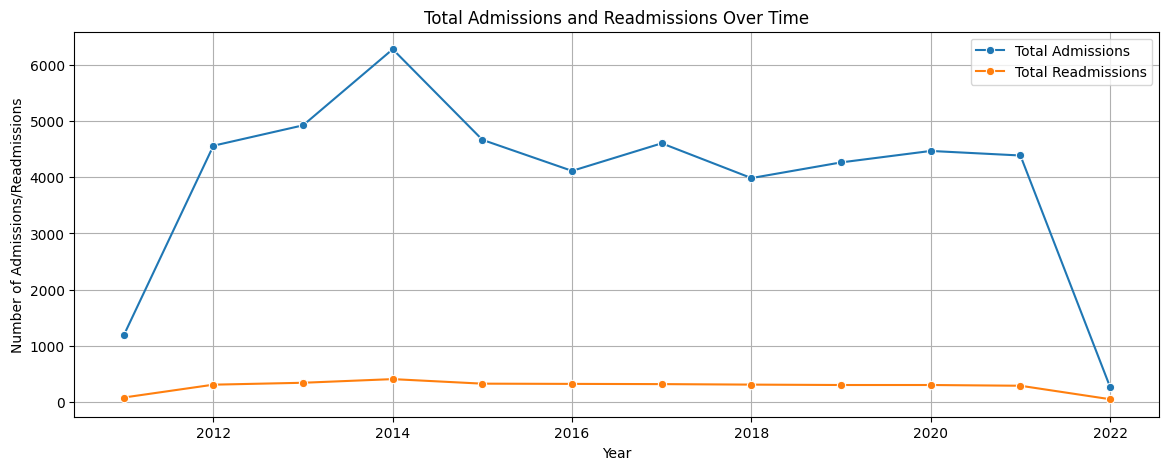

In [51]:
# Count total admissions by patient
admissions_count = final_dataset.groupby('Patient_ID').size().reset_index(name='Total_Admissions')

# Identify readmissions (patients with more than one encounter)
readmissions = admissions_count[admissions_count['Total_Admissions'] > 1]

# Analyze admissions over time
# Extract year from Encounter_Start for time-based analysis
final_dataset['Encounter_Year'] = final_dataset['Encounter_Start'].dt.year

# Group by year to count admissions
admissions_over_time = final_dataset.groupby('Encounter_Year').size().reset_index(name='Total_Admissions')

# Group by year and patient to count readmissions
readmissions_over_time = final_dataset.groupby(['Encounter_Year', 'Patient_ID']).size().reset_index(name='Admissions_Count')
readmissions_over_time = readmissions_over_time[readmissions_over_time['Admissions_Count'] > 1]

# Count the number of readmissions per year
readmissions_over_time = readmissions_over_time.groupby('Encounter_Year').size().reset_index(name='Total_Readmissions')

# Plotting the data
plt.figure(figsize=(14, 5))

# Total Admissions Plot
sns.lineplot(data=admissions_over_time, x='Encounter_Year', y='Total_Admissions', marker='o', label='Total Admissions')

# Total Readmissions Plot
sns.lineplot(data=readmissions_over_time, x='Encounter_Year', y='Total_Readmissions', marker='o', label='Total Readmissions')

# Adding titles and labels
plt.title('Total Admissions and Readmissions Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Admissions/Readmissions')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

#### How long are patients staying in the hospital, on average?

In [45]:
# Calculate the duration of each encounter
final_dataset['Encounter_Duration'] = (final_dataset['Encounter_Stop'] - final_dataset['Encounter_Start']).dt.total_seconds() / (24 * 60 * 60)

# Compute the average length of stay
average_length_of_stay = final_dataset['Encounter_Duration'].mean()

# Display the result
print(f"The average length of stay in the hospital is {average_length_of_stay:.2f} days.")

The average length of stay in the hospital is 0.22 days.


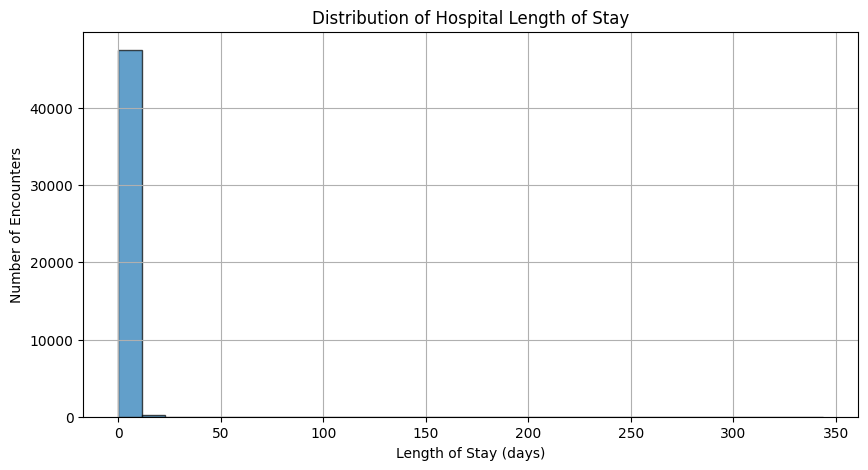

In [50]:
# Plot the distribution of the length of stay
plt.figure(figsize=(10, 5))
plt.hist(final_dataset['Encounter_Duration'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Hospital Length of Stay')
plt.xlabel('Length of Stay (days)')
plt.ylabel('Number of Encounters')
plt.grid(True)
plt.show()

#### How much is the average cost per visit?

In [47]:
# Compute the average cost per visit
average_cost_per_visit = final_dataset['Total_Claim_Cost'].mean()

# Display the result
print(f"The average cost per visit is ${average_cost_per_visit:.2f}.")

The average cost per visit is $8306.26.


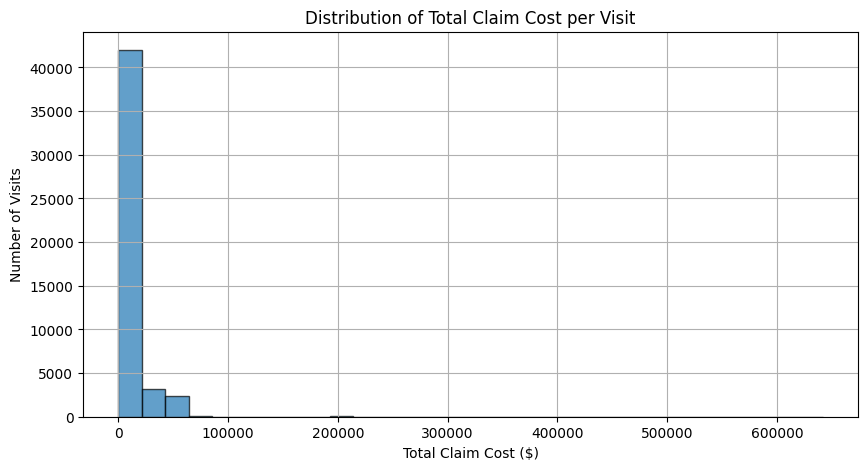

In [49]:
# Plot the distribution of the total claim cost
plt.figure(figsize=(10, 5))
plt.hist(final_dataset['Total_Claim_Cost'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Total Claim Cost per Visit')
plt.xlabel('Total Claim Cost ($)')
plt.ylabel('Number of Visits')
plt.grid(True)
plt.show()